In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch.nn as nn
import torch
import torchvision
from torchvision import models, transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR

import numpy as np
import random

%matplotlib inline
import matplotlib.pyplot as plt

from copy import deepcopy

basepath = '/content/drive/MyDrive/pruning test'

In [ ]:
class EarlyStopping:
    def __init__(self, patience=7, filename='checkpoint_0', verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.filename = filename

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose: print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(),basepath+'/CheckPoints/'+self.filename+'.pt')
        self.val_loss_min = val_loss

In [ ]:
def get_data_loaders():
  transform = transforms.Compose([transforms.Resize((32,32)),transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])
  cifar10_train = torchvision.datasets.CIFAR10('../data',transform=transform,train=True,download=True)
  cifar10_test = torchvision.datasets.CIFAR10('../data',transform=transform,train=False,download=True)
  data_loader_train = torch.utils.data.DataLoader(cifar10_train, batch_size=1024, shuffle=True, num_workers=8)
  data_loader_test = torch.utils.data.DataLoader(cifar10_test, batch_size=2048, shuffle=True, num_workers=8)
  return(data_loader_train,data_loader_test)

data_loader_train,data_loader_test = get_data_loaders()

In [ ]:
def defineMasks():
  mask_conv1 = torch.ones(64,3,3,3)
  mask_conv2 = torch.ones(192,64,3,3)
  mask_conv3 = torch.ones(384,192,3,3)
  mask_conv4 = torch.ones(256,384,3,3)
  mask_conv5 = torch.ones(256,256,3,3)
  mask_linear1 = torch.ones(4096,256*2*2)
  mask_linear2 = torch.ones(4096,4096)
  mask_linear3 = torch.ones(10,4096)
  return mask_conv1, mask_conv2, mask_conv3, mask_conv4, mask_conv5, mask_linear1, mask_linear2, mask_linear3

In [ ]:
class AlexNet(nn.Module):

    def __init__(self):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 2 * 2, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 10),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 2 * 2)
        x = self.classifier(x)
        return x


In [ ]:
num_classes = 10
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

mask_conv1, mask_conv2, mask_conv3, mask_conv4, mask_conv5, mask_linear1, mask_linear2, mask_linear3 = defineMasks()

def get_unpruned_model(num_classes):
  model = AlexNet()
  return(model)

model = get_unpruned_model(num_classes)

In [ ]:
def plot_losses(train_loss,test_loss,filename,i):
  x_axis = list(range(1,len(train_loss)+1))
  fig = plt.figure(i,figsize=(20,10))
  plt.axes(yscale='log')
  plt.plot(x_axis, train_loss, color='blue', label='Train Loss Loss')
  plt.plot(x_axis, test_loss, color='green', label='Validation Loss')
  plt.legend(loc=1)
  plt.xlabel('Iterations over entire dataset')
  plt.ylabel('Loss')
  plt.ylim(0.01,3)
  plt.savefig(basepath+'/Losses/'+filename+'.png')
  plt.close(fig)

def plot_accuracies(train_accuracy,test_accuracy,filename,i):
  x_axis = list(range(1,len(train_accuracy)+1))
  fig = plt.figure(i,figsize=(20,10))
  plt.yscale('log')
  plt.plot(x_axis, train_accuracy, color='blue', label='Train Accuracy')
  plt.plot(x_axis, test_accuracy, color='green', label='Validation Accuracy')
  plt.legend(loc=1)
  plt.xlabel('Iterations over entire dataset')
  plt.ylabel('Accuracy')
  plt.ylim(0.1,1)
  plt.savefig(basepath+'/Accuracies/'+filename+'.png')
  plt.close(fig)

In [ ]:
def train(model,prune_itr,lr_multiplier=1):

  scale_factor = 16

  learning_rate = 1e-3*lr_multiplier; wt_dcy =1e-7; lr_patience = int(2000/scale_factor); lr_stepsize = int(3000/scale_factor); es_patience = int(5000/scale_factor)
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=wt_dcy)
  scheduler_plateau = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=lr_patience, verbose=True, threshold=1e-7)
  scheduler_stepLR = StepLR(optimizer, step_size=lr_stepsize, gamma=0.8)
  early_stopping = EarlyStopping(patience=es_patience,filename='checkpoint_'+str(prune_itr), verbose=True)

  torch.cuda.empty_cache()
  model = model.to(device)
  num_epochs = 50
  es_flag = 0

  train_loss = []; test_loss = []; train_accuracy = []; test_accuracy = []

  best_loss = 100000; best_accuracy = 2

  for epoch in range(num_epochs):

    correct = 0; data_size = 0; t_loss = 0

    for i, (images, labels) in enumerate(data_loader_train):

      model.train()
      images = images.to(device); labels = labels.to(device)
      data_size += len(images)
      outputs = torch.nn.functional.log_softmax(model(images), dim=1)
      trainloss = criterion(outputs,labels)
      optimizer.zero_grad()
      trainloss.backward()
      optimizer.step()
      _, predicted = torch.max(outputs.data, 1)
      correct += (predicted == labels).sum().item()
      t_loss += trainloss.item()

      correct_t = 0; data_size_t = 0; tt_loss = 0
      model.eval()
      with torch.no_grad():
        for images, labels in data_loader_test:
          images = images.to(device); labels = labels.to(device)
          data_size_t += len(images)
          outputs = torch.nn.functional.log_softmax(model(images), dim=1)
          _, predicted = torch.max(outputs.data, 1)
          correct_t += (predicted == labels).sum().item()
          tt_loss += criterion(outputs, labels).item()
      print('Epoch: {}, Batch: {}, Train Loss: {:.3f} Train Accuracy: {:.3f}%, Validation Loss: {:.3f} Validation Accuracy: {:.3f}%'.
            format(epoch+1, i+1, trainloss.item(), 100*(predicted==labels).sum().item()/len(images), tt_loss/len(data_loader_test), 100*correct_t/data_size_t))

      train_loss.append(trainloss.item()); test_loss.append(tt_loss/len(data_loader_test))
      train_accuracy.append((predicted==labels).sum().item()/len(images)); test_accuracy.append(correct_t/data_size_t)

      if (tt_loss/len(data_loader_test)) < best_loss:
        best_loss = tt_loss/len(data_loader_test)
        best_accuracy = correct_t/data_size_t


      scheduler_stepLR.step()
      scheduler_plateau.step(tt_loss/len(data_loader_test))

      early_stopping(tt_loss/len(data_loader_test), model)
      if early_stopping.early_stop:
        print("Early stopping")
        es_flag = 1
        break
    if es_flag == 1: break

  model.load_state_dict(torch.load(basepath+'/CheckPoints/'+'checkpoint_'+str(prune_itr)+'.pt'))

  return(model,train_loss,test_loss,train_accuracy,test_accuracy,best_loss,best_accuracy)

Epoch: 1, Batch: 1, Train Loss: 2.496 Train Accuracy: 9.735%, Validation Loss: 2.304 Validation Accuracy: 10.000%
Validation loss decreased (inf --> 2.303632).  Saving model ...
Epoch: 1, Batch: 2, Train Loss: 2.309 Train Accuracy: 10.232%, Validation Loss: 2.304 Validation Accuracy: 10.000%
EarlyStopping counter: 1 out of 312
Epoch: 1, Batch: 3, Train Loss: 2.308 Train Accuracy: 10.066%, Validation Loss: 2.303 Validation Accuracy: 10.000%
Validation loss decreased (2.303632 --> 2.302918).  Saving model ...
Epoch: 1, Batch: 4, Train Loss: 2.303 Train Accuracy: 10.730%, Validation Loss: 2.301 Validation Accuracy: 10.000%
Validation loss decreased (2.302918 --> 2.300801).  Saving model ...
Epoch: 1, Batch: 5, Train Loss: 2.301 Train Accuracy: 10.343%, Validation Loss: 2.297 Validation Accuracy: 10.000%
Validation loss decreased (2.300801 --> 2.296775).  Saving model ...
Epoch: 1, Batch: 6, Train Loss: 2.298 Train Accuracy: 9.790%, Validation Loss: 2.298 Validation Accuracy: 10.830%
Early

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/pruning test/Losses/l0.png'

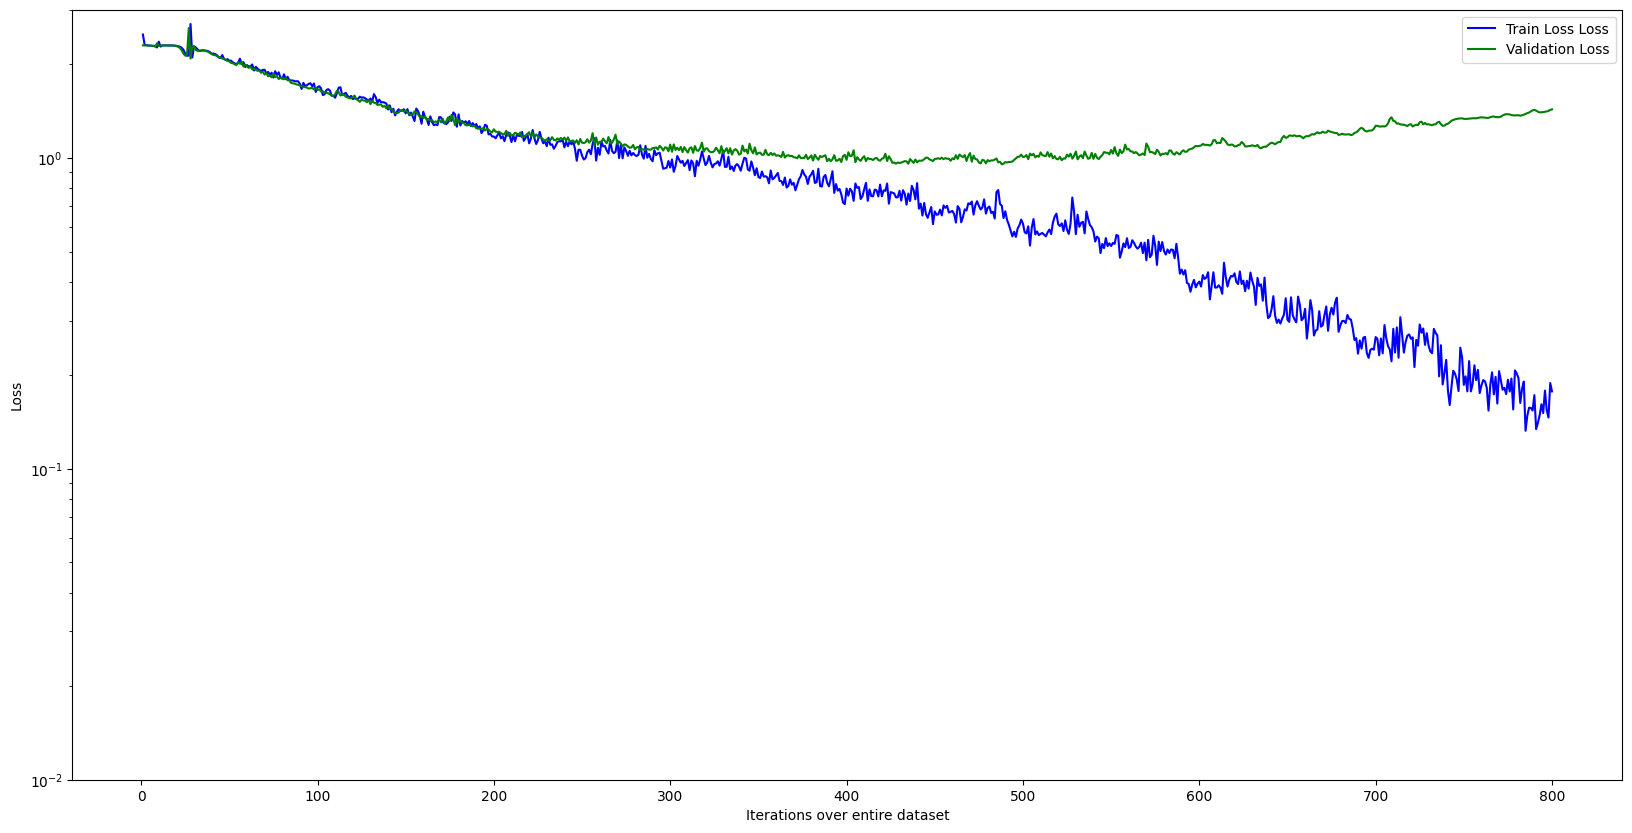

In [ ]:
lr_multiplier = 1
dict_best_info = {}
#4model.load_state_dict(torch.load(basepath+'/CheckPoints/'+'checkpoint_0.pt'))
model,train_loss,test_loss,train_accuracy,test_accuracy,best_loss,best_accuracy = train(model,0,lr_multiplier)
dict_best_info[0] = (best_loss,best_accuracy)
plot_losses(train_loss,test_loss,'l0',1)
plot_accuracies(train_accuracy,test_accuracy,'a0',2)

model.load_state_dict(torch.load(basepath+'/CheckPoints/'+'checkpoint_0.pt'))
model = model.to(device)
print(model)

print('Best Accuracy is ' + str(round(best_accuracy*100,2)))
print('Best Loss is ' + str(round(best_loss,3)))

In [ ]:
def get_model_layerwise_analysis(model):

  for layer, (name, module) in enumerate(model.features._modules.items()):
    if name == '0':
      weights = torch.abs(module.weight).cpu()
      print(weights.max(),weights.mean(),weights.std())
    if name == '3':
      weights = torch.abs(module.weight).cpu()
      print(weights.max(),weights.mean(),weights.std())
    if name == '6':
      weights = torch.abs(module.weight).cpu()
      print(weights.max(),weights.mean(),weights.std())
    if name == '8':
      weights = torch.abs(module.weight).cpu()
      print(weights.max(),weights.mean(),weights.std())
    if name == '10':
      weights = torch.abs(module.weight).cpu()
      print(weights.max(),weights.mean(),weights.std())

  for layer, (name, module) in enumerate(model.classifier._modules.items()):
    if name == '1':
      weights = torch.abs(module.weight).cpu()
      print(weights.max(),weights.mean(),weights.std())
    if name == '4':
      weights = torch.abs(module.weight).cpu()
      print(weights.max(),weights.mean(),weights.std())
    if name == '6':
      weights = torch.abs(module.weight).cpu()
      print(weights.max(),weights.mean(),weights.std())

get_model_layerwise_analysis(model)

tensor(0.2387, grad_fn=<MaxBackward1>) tensor(0.0961, grad_fn=<MeanBackward0>) tensor(0.0572, grad_fn=<StdBackward0>)
tensor(0.1601, grad_fn=<MaxBackward1>) tensor(0.0234, grad_fn=<MeanBackward0>) tensor(0.0158, grad_fn=<StdBackward0>)
tensor(0.2117, grad_fn=<MaxBackward1>) tensor(0.0155, grad_fn=<MeanBackward0>) tensor(0.0140, grad_fn=<StdBackward0>)
tensor(0.2035, grad_fn=<MaxBackward1>) tensor(0.0114, grad_fn=<MeanBackward0>) tensor(0.0128, grad_fn=<StdBackward0>)
tensor(0.1642, grad_fn=<MaxBackward1>) tensor(0.0103, grad_fn=<MeanBackward0>) tensor(0.0107, grad_fn=<StdBackward0>)
tensor(0.1543, grad_fn=<MaxBackward1>) tensor(0.0150, grad_fn=<MeanBackward0>) tensor(0.0122, grad_fn=<StdBackward0>)
tensor(0.1358, grad_fn=<MaxBackward1>) tensor(0.0088, grad_fn=<MeanBackward0>) tensor(0.0073, grad_fn=<StdBackward0>)
tensor(0.1049, grad_fn=<MaxBackward1>) tensor(0.0102, grad_fn=<MeanBackward0>) tensor(0.0094, grad_fn=<StdBackward0>)


In [ ]:
initial_parameters = sum([p.numel() for p in model.parameters()])

In [ ]:
def count_nonzeros(model):
  nonzeros = 0
  for param in model.parameters():
    if param is not None: nonzeros += torch.sum((param != 0).int()).item()
  return(nonzeros)

In [ ]:
def update_masks(model, mask_conv1, mask_conv2, mask_conv3, mask_conv4, mask_conv5, mask_linear1, mask_linear2, mask_linear3, k1, k2, k3, k4, k5, k6, k7, k8):

  for layer, (name, module) in enumerate(model.features._modules.items()):
    if name == '0':
      a_c1 = 0.17*torch.abs(module.weight.max()).data * k1
      t_c1 = 1*torch.abs(module.weight.std()).data
      b_c1 = a_c1 + t_c1
    if name == '3':
      a_c2 = 0.2*torch.abs(module.weight.max()).data * k2
      t_c2 = 2*torch.abs(module.weight.std()).data
      b_c2 = a_c2 + t_c2
    if name == '6':
      a_c3 = 0.2*torch.abs(module.weight.max()).data * k3
      t_c3 = 2*torch.abs(module.weight.std()).data
      b_c3 = a_c3 + t_c3
    if name == '8':
      a_c4 = 0.25*torch.abs(module.weight.max()).data * k4
      t_c4 = 2*torch.abs(module.weight.std()).data
      b_c4 = a_c4 + t_c4
    if name == '10':
      a_c5 = 0.25*torch.abs(module.weight.max()).data * k5
      t_c5 = 2*torch.abs(module.weight.std()).data
      b_c5 = a_c5 + t_c5

  for layer, (name, module) in enumerate(model.classifier._modules.items()):
    if name == '1':
      a_l1 = 0.35*torch.abs(module.weight.max()).data * k6
      t_l1 = 2*torch.abs(module.weight.std()).data
      b_l1 = a_l1 + t_l1
    if name == '4':
      a_l2 = 0.25*torch.abs(module.weight.max()).data * k7
      t_l2 = 1*torch.abs(module.weight.std()).data
      b_l2 = a_l2 + t_l2
    if name == '6':
      a_l3 = 0.2*torch.abs(module.weight.max()).data * k8
      t_l3 = 1*torch.abs(module.weight.std()).data
      b_l3 = a_l3 + t_l3

  for layer, (name, module) in enumerate(model.features._modules.items()):
    if name == '0':
      weights = torch.abs(module.weight).cpu()
      # Move b_c1 and a_c1 to CPU before comparison
      temp_mask1 = (weights > b_c1.cpu()).float() * 1
      temp_mask2 = (weights > a_c1.cpu()).float() * 1
      temp_mask = (temp_mask2 * mask_conv1) + temp_mask1
      mask_conv1 = (temp_mask >= 1.).float() * 1
    if name == '3':
      weights = torch.abs(module.weight).cpu()
      # Move b_c2 and a_c2 to CPU before comparison
      temp_mask1 = (weights > b_c2.cpu()).float() * 1
      temp_mask2 = (weights > a_c2.cpu()).float() * 1
      temp_mask = (temp_mask2 * mask_conv2) + temp_mask1
      mask_conv2 = (temp_mask >= 1.).float() * 1
    if name == '6':
      weights = torch.abs(module.weight).cpu()
      # Move b_c3 and a_c3 to CPU before comparison
      temp_mask1 = (weights > b_c3.cpu()).float() * 1
      temp_mask2 = (weights > a_c3.cpu()).float() * 1
      temp_mask = (temp_mask2 * mask_conv3) + temp_mask1
      mask_conv3 = (temp_mask >= 1.).float() * 1
    if name == '8':
      weights = torch.abs(module.weight).cpu()
      # Move b_c4 and a_c4 to CPU before comparison
      temp_mask1 = (weights > b_c4.cpu()).float() * 1
      temp_mask2 = (weights > a_c4.cpu()).float() * 1
      temp_mask = (temp_mask2 * mask_conv4) + temp_mask1
      mask_conv4 = (temp_mask >= 1.).float() * 1
    if name == '10':
      weights = torch.abs(module.weight).cpu()
      # Move b_c5 and a_c5 to CPU before comparison
      temp_mask1 = (weights > b_c5.cpu()).float() * 1
      temp_mask2 = (weights > a_c5.cpu()).float() * 1
      temp_mask = (temp_mask2 * mask_conv5) + temp_mask1
      mask_conv5 = (temp_mask >= 1.).float() * 1


  for layer, (name, module) in enumerate(model.classifier._modules.items()):
    if name == '1':
      weights = torch.abs(module.weight).cpu()
      # Move b_l1 and a_l1 to CPU before comparison
      temp_mask1 = (weights > b_l1.cpu()).float() * 1
      temp_mask2 = (weights > a_l1.cpu()).float() * 1
      temp_mask = (temp_mask2 * mask_linear1) + temp_mask1
      mask_linear1 = (temp_mask >= 1.).float() * 1
    if name == '4':
      weights = torch.abs(module.weight).cpu()
      # Move b_l2 and a_l2 to CPU before comparison
      temp_mask1 = (weights > b_l2.cpu()).float() * 1
      temp_mask2 = (weights > a_l2.cpu()).float() * 1
      temp_mask = (temp_mask2 * mask_linear2) + temp_mask1
      mask_linear2 = (temp_mask >= 1.).float() * 1
    if name == '6':
      weights = torch.abs(module.weight).cpu()
      # Move b_l3 and a_l3 to CPU before comparison
      temp_mask1 = (weights > b_l3.cpu()).float() * 1
      temp_mask2 = (weights > a_l3.cpu()).float() * 1
      temp_mask = (temp_mask2 * mask_linear3) + temp_mask1
      mask_linear3 = (temp_mask >= 1.).float() * 1


  return mask_conv1, mask_conv2, mask_conv3, mask_conv4, mask_conv5, mask_linear1, mask_linear2, mask_linear3

In [ ]:
def model_surgery(model, mask_conv1, mask_conv2, mask_conv3, mask_conv4, mask_conv5, mask_linear1, mask_linear2, mask_linear3):

  for layer, (name, module) in enumerate(model.features._modules.items()):
    if name == '0':
      weights = (module.weight.data) * mask_conv1.to(device)
      model.features._modules[name].weight.data = weights.to(device)
    if name == '3':
      weights = (module.weight.data) * mask_conv2.to(device)
      model.features._modules[name].weight.data = weights.to(device)
    if name == '6':
      weights = (module.weight.data) * mask_conv3.to(device)
      model.features._modules[name].weight.data = weights.to(device)
    if name == '8':
      weights = (module.weight.data) * mask_conv4.to(device)
      model.features._modules[name].weight.data = weights.to(device)
    if name == '10':
      weights = (module.weight.data) * mask_conv5.to(device)
      model.features._modules[name].weight.data = weights.to(device)

  for layer, (name, module) in enumerate(model.classifier._modules.items()):
    if name == '1':
      weights = (module.weight.data) * mask_linear1.to(device)
      model.classifier._modules[name].weight.data = weights.to(device)
    if name == '4':
      weights = (module.weight.data) * mask_linear2.to(device)
      model.classifier._modules[name].weight.data = weights.to(device)
    if name == '6':
      weights = (module.weight.data) * mask_linear3.to(device)
      model.classifier._modules[name].weight.data = weights.to(device)

  for param in model.parameters(): param.requires_grad = True

  return(model)

In [ ]:
def perform_surgery_training(model, prune_itr, lr_multiplier, mask_conv1, mask_conv2, mask_conv3, mask_conv4, mask_conv5, mask_linear1, mask_linear2, mask_linear3):

  scale_factor = 16

  learning_rate = 1e-3*lr_multiplier; wt_dcy =1e-7; lr_patience = int(2000/scale_factor); lr_stepsize = 1; es_patience = int(10000/scale_factor)
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=wt_dcy)
  scheduler_plateau = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=lr_patience, verbose=True, threshold=1e-7)
  scheduler_stepLR = StepLR(optimizer, step_size=lr_stepsize, gamma=0.995)
  early_stopping = EarlyStopping(patience=es_patience,filename='checkpoint_'+str(prune_itr), verbose=True)

  torch.cuda.empty_cache()
  model = model.to(device)
  num_epochs = 70
  es_flag = 0

  final_model = deepcopy(model)

  train_loss = []; test_loss = []; train_accuracy = []; test_accuracy = []

  nonzero_parameter_list = []

  best_loss = 100000; best_accuracy = 2; best_parameter_size = 0

  prob_itr = 0; prob_threshold = 1.0; k1 = 1; k2 = 1; k3 = 1; k4 = 1; k5 = 1; k6 = 1; k7 = 1; k8 = 1

  for epoch in range(num_epochs):

    correct = 0; data_size = 0; t_loss = 0

    for i, (images, labels) in enumerate(data_loader_train):

      model.train()
      images = images.to(device); labels = labels.to(device)
      data_size += len(images)
      outputs = torch.nn.functional.log_softmax(model(images), dim=1)
      trainloss = criterion(outputs,labels)
      optimizer.zero_grad()
      trainloss.backward()

      choice = random.random()
      if choice <= prob_threshold:
        print('Performing Surgery for choice as ' + str(round(choice,4)) + ' for threshold ' + str(round(prob_threshold,4)) + '.')
        mask_conv1, mask_conv2, mask_conv3, mask_conv4, mask_conv5, mask_linear1, mask_linear2, mask_linear3 = update_masks(model,mask_conv1, mask_conv2, mask_conv3, mask_conv4, mask_conv5, mask_linear1, mask_linear2, mask_linear3, k1, k2, k3, k4, k5, k6, k7, k8)
        k1 = k1 * 1.00015; k2 = k2 * 1.00014; k3 = k3 * 1.0001; k4 = k4 * 1.0001; k5 = k5 * 1.0001; k6 = k6 * 1.00007; k7 = k7 * 1.00012; k8 = k8 * 1.0009

      optimizer.step()
      model = model_surgery(model, mask_conv1, mask_conv2, mask_conv3, mask_conv4, mask_conv5, mask_linear1, mask_linear2, mask_linear3)

      prob_itr += 1
      prob_threshold *= 0.9993
      nonzero_parameters = count_nonzeros(model)
      nonzero_parameter_list.append(nonzero_parameters)
      print('Parameters are: ' + str(nonzero_parameters))

      _, predicted = torch.max(outputs.data, 1)
      correct += (predicted == labels).sum().item()
      t_loss += trainloss.item()

      correct_t = 0; data_size_t = 0; tt_loss = 0

      model.eval()
      with torch.no_grad():
        for images, labels in data_loader_test:
          images = images.to(device); labels = labels.to(device)
          data_size_t += len(images)
          outputs = torch.nn.functional.log_softmax(model(images), dim=1)
          _, predicted = torch.max(outputs.data, 1)
          correct_t += (predicted == labels).sum().item()
          tt_loss += criterion(outputs, labels).item()
      print('Epoch: {}, Batch: {}, Train Loss: {:.3f} Train Accuracy: {:.3f}%, Validation Loss: {:.3f} Validation Accuracy: {:.3f}%'.
            format(epoch+1, i+1, trainloss.item(), 100*(predicted==labels).sum().item()/len(images), tt_loss/len(data_loader_test), 100*correct_t/data_size_t))

      train_loss.append(trainloss.item()); test_loss.append(tt_loss/len(data_loader_test))
      train_accuracy.append((predicted==labels).sum().item()/len(images)); test_accuracy.append(correct_t/data_size_t)

      if (tt_loss/len(data_loader_test)) < best_loss:
        best_loss = tt_loss/len(data_loader_test)
        best_accuracy = correct_t/data_size_t
        best_parameter_size = nonzero_parameters

      scheduler_stepLR.step()
      scheduler_plateau.step(tt_loss/len(data_loader_test))

      early_stopping(tt_loss/len(data_loader_test), model)
      if early_stopping.early_stop:
        print("Early stopping")
        es_flag = 1
        break
    if es_flag == 1: break

  if (correct_t/data_size_t) >= (best_accuracy-(0.1*best_accuracy)):
    last_loss = tt_loss/len(data_loader_test)
    last_accuracy = correct_t/data_size_t
    last_parameter_size = nonzero_parameters
    final_model = deepcopy(model)

  model.load_state_dict(torch.load(basepath+'/CheckPoints/'+'checkpoint_'+str(prune_itr)+'.pt'))

  return(model, final_model, train_loss, test_loss, train_accuracy, test_accuracy, best_loss, best_accuracy, best_parameter_size, last_loss, last_accuracy, last_parameter_size, nonzero_parameter_list)

In [ ]:
def plot_parameters(parameter_list,filename,i):
  x_axis = list(range(1,len(parameter_list)+1))
  fig = plt.figure(i,figsize=(20,10))
  plt.plot(x_axis, parameter_list, color='blue', label='Total Parameters')
  plt.legend(loc=1)
  plt.xlabel('Iterations over entire dataset')
  plt.ylabel('Parameters')
  plt.ylim(0,70000)
  plt.savefig(basepath+'/Parameters/'+filename+'.png')
  plt.close(fig)

In [ ]:
mask_conv1, mask_conv2, mask_conv3, mask_conv4, mask_conv5, mask_linear1, mask_linear2, mask_linear3 = defineMasks()
lr_multiplier = 1
new_model = deepcopy(model)
#new_model.load_state_dict(torch.load(basepath+'/CheckPoints/'+'checkpoint_1.pt'))
pruned_model, final_model, train_loss, test_loss, train_accuracy, test_accuracy, best_loss, best_accuracy, best_parameter_size, last_loss, last_accuracy, last_parameter_size, parameter_list = perform_surgery_training(new_model,1,lr_multiplier,mask_conv1, mask_conv2, mask_conv3, mask_conv4, mask_conv5, mask_linear1, mask_linear2, mask_linear3)
dict_best_info[1] = (best_loss,best_accuracy)
plot_losses(train_loss,test_loss,'l1',1)
plot_accuracies(train_accuracy,test_accuracy,'a1',2)
plot_parameters(parameter_list,'p1',3)

pruned_model.load_state_dict(torch.load(basepath+'/CheckPoints/'+'checkpoint_1.pt'))
pruned_model = pruned_model.to(device)
print(pruned_model)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Performing Surgery for choice as 0.266 for threshold 1.0.
Parameters are: 323117
Epoch: 1, Batch: 1, Train Loss: 0.572 Train Accuracy: 10.011%, Validation Loss: 2.307 Validation Accuracy: 10.000%
Validation loss decreased (inf --> 2.307097).  Saving model ...
Performing Surgery for choice as 0.6301 for threshold 0.9993.
Parameters are: 310225
Epoch: 1, Batch: 2, Train Loss: 2.309 Train Accuracy: 11.394%, Validation Loss: 2.300 Validation Accuracy: 11.800%
Validation loss decreased (2.307097 --> 2.299946).  Saving model ...
Performing Surgery for choice as 0.7758 for threshold 0.9986.
Parameters are: 303610
Epoch: 1, Batch: 3, Train Loss: 2.313 Train Accuracy: 18.916%, Validation Loss: 2.281 Validation Accuracy: 19.030%
Validation loss decreased (2.299946 --> 2.281078).  Saving model ...
Performing Surgery for choice as 0.9387 for threshold 0.9979.
Parameters are: 297379
Epoch: 1, Batch: 4, Train Loss: 2.268 Train Accuracy: 18.252%, Validation Loss: 2.261 Validation Accuracy: 17.550%
Va

In [ ]:
pruned_model = deepcopy(model)
pruned_model.load_state_dict(torch.load(basepath+'/CheckPoints/'+'checkpoint_1.pt',map_location=lambda storage, loc: storage))
pruned_model = pruned_model.to(device)
print(pruned_model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=1024, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, in

In [ ]:
get_model_layerwise_analysis(pruned_model)

tensor(0.2712, grad_fn=<MaxBackward1>) tensor(0.0907, grad_fn=<MeanBackward0>) tensor(0.0694, grad_fn=<StdBackward0>)
tensor(0.1960, grad_fn=<MaxBackward1>) tensor(0.0101, grad_fn=<MeanBackward0>) tensor(0.0220, grad_fn=<StdBackward0>)
tensor(0.2020, grad_fn=<MaxBackward1>) tensor(0.0025, grad_fn=<MeanBackward0>) tensor(0.0134, grad_fn=<StdBackward0>)
tensor(0.2162, grad_fn=<MaxBackward1>) tensor(0.0011, grad_fn=<MeanBackward0>) tensor(0.0095, grad_fn=<StdBackward0>)
tensor(0.1863, grad_fn=<MaxBackward1>) tensor(0.0020, grad_fn=<MeanBackward0>) tensor(0.0122, grad_fn=<StdBackward0>)
tensor(0.1943, grad_fn=<MaxBackward1>) tensor(0.0006, grad_fn=<MeanBackward0>) tensor(0.0075, grad_fn=<StdBackward0>)
tensor(0.1652, grad_fn=<MaxBackward1>) tensor(0.0008, grad_fn=<MeanBackward0>) tensor(0.0075, grad_fn=<StdBackward0>)
tensor(0.1337, grad_fn=<MaxBackward1>) tensor(0.0072, grad_fn=<MeanBackward0>) tensor(0.0210, grad_fn=<StdBackward0>)


In [ ]:
remaining_parameters = count_nonzeros(pruned_model)
print('For Compression without loss...')
print('Number of Initial Parameters are ' + str(initial_parameters))
print('Number of Remaining Parameters are ' + str(remaining_parameters))
print('Compression Rate without loss is ' + str(initial_parameters/remaining_parameters))
print('Best Accuracy is ' + str(round(best_accuracy*100,2)))
print('Best Loss is ' + str(round(best_loss,3)))

For Compression without loss...
Number of Initial Parameters are 23272266
Number of Remaining Parameters are 294320
Compression Rate without loss is 79.0713033432998


In [ ]:
def layer_wise_comparison(model,pruned_model):
  selected_layers = [0,2,4,6,8,10,12,14]
  model_layers = []
  for param in model.parameters():
    if param is not None: model_layers.append(torch.sum((param != 0).int()).item())

  pruned_model_layers = []
  for param in pruned_model.parameters():
    if param is not None: pruned_model_layers.append(torch.sum((param != 0).int()).item())

  for i in range(len(model_layers)):
    if i in selected_layers:
      print('Layer Parameters: ' + str(model_layers[i]) + ', Parameters Left: ' + str(pruned_model_layers[i]) + ', Percentage Left: ' + str(round(pruned_model_layers[i]*100/model_layers[i],2)))

print('For Compression without loss...')
layer_wise_comparison(model,pruned_model)

For Compression without loss...
Layer Parameters: 1728, Parameters Left: 1237, Percentage Left: 71.59
Layer Parameters: 110592, Parameters Left: 21015, Percentage Left: 19.0
Layer Parameters: 663552, Parameters Left: 24457, Percentage Left: 3.69
Layer Parameters: 884736, Parameters Left: 11449, Percentage Left: 1.29
Layer Parameters: 589824, Parameters Left: 16892, Percentage Left: 2.86
Layer Parameters: 4194304, Parameters Left: 23624, Percentage Left: 0.56
Layer Parameters: 16777215, Parameters Left: 181761, Percentage Left: 1.08
Layer Parameters: 40960, Parameters Left: 4531, Percentage Left: 11.06


In [ ]:
print('For Best Compression...')
layer_wise_comparison(model,final_model)

In [ ]:
print('Trained for '+str(last_parameter_size)+' non-zero parameters reaching '+str(initial_parameters/last_parameter_size)+' times compression with loss '+str(round(last_loss,3))+' and accuracy '+str(round(last_accuracy*100,2))+'%.')